### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/washington/2023_07_14_09_29_01/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/washington/2023_07_14_09_29_01/count_data'

## Checking Stability of Risks over Time

In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,6695.545517
1,25_to_29,Female,2023,232,6677.070500
2,25_to_29,Female,2023,357,3313.007529
3,25_to_29,Female,2023,394,6703.748118
4,25_to_29,Female,2023,602,4945.478439


In [6]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [7]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,194415.032093
1,1,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,lifestyle_100,25_to_29,194415.032093
2,2,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,outreach_100,25_to_29,194415.032093
3,3,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,polypill_100,25_to_29,194415.032093
4,4,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,210864.596493


In [8]:
bmi_exp = risk_exp.loc[(risk_exp['risk']=='high_body_mass_index_in_adults') & (risk_exp['scenario']=='baseline')]
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,194415.032093
4,4,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,210864.596493
8,8,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,216325.755005
12,12,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,207699.681671
16,16,Female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,197925.869155


In [9]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,149946.768769,94494.574729,196658.415604
1,25_to_29,Female,2024,146899.820948,93190.272095,192974.315393
2,25_to_29,Female,2025,144109.481347,91509.693981,189068.280563
3,25_to_29,Female,2026,142723.052312,90081.079136,186939.800321
4,25_to_29,Female,2027,141982.214419,89583.078100,185811.527531


In [10]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [11]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']

In [12]:
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,Female,2023,28.862456,28.900190,28.483965,29.094365
1,25_to_29,Female,2024,28.902101,28.889032,28.618265,29.170052
2,25_to_29,Female,2025,28.921122,28.934125,28.636438,29.217923
3,25_to_29,Female,2026,28.962683,28.960807,28.637566,29.236742
4,25_to_29,Female,2027,28.931275,28.940887,28.614686,29.166204


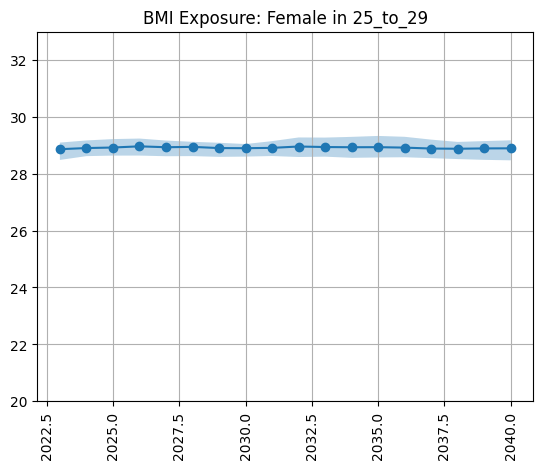

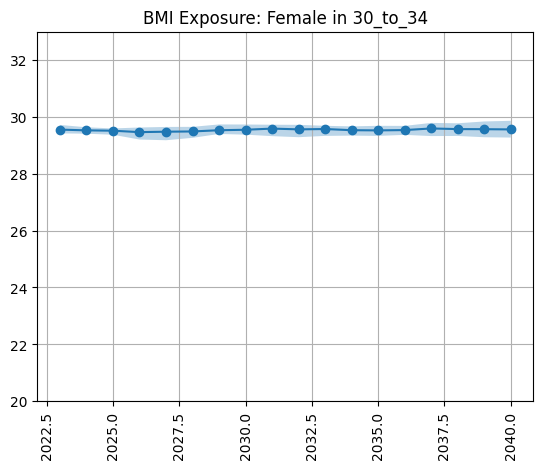

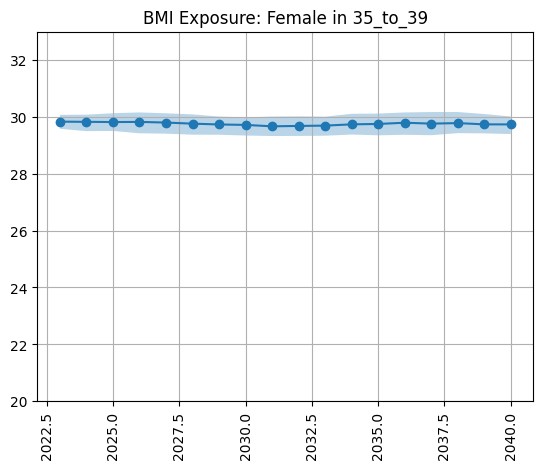

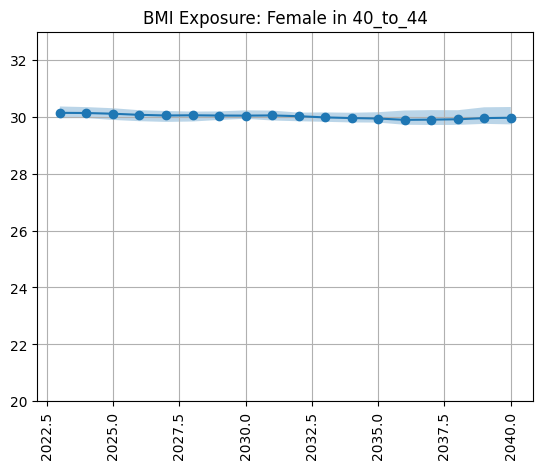

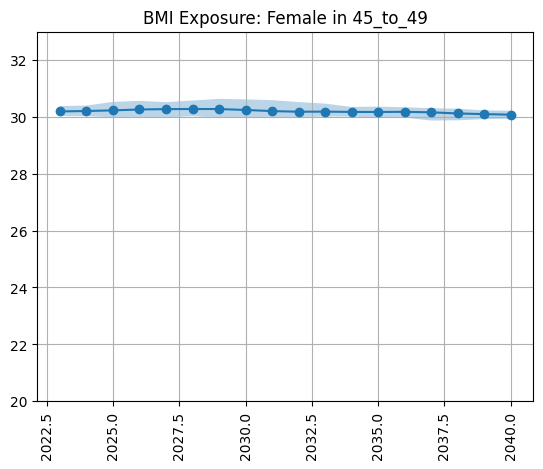

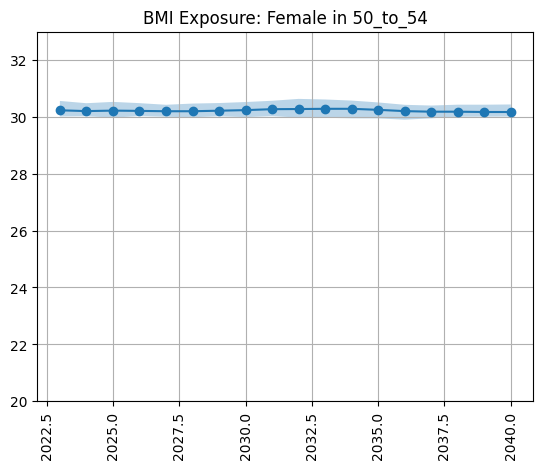

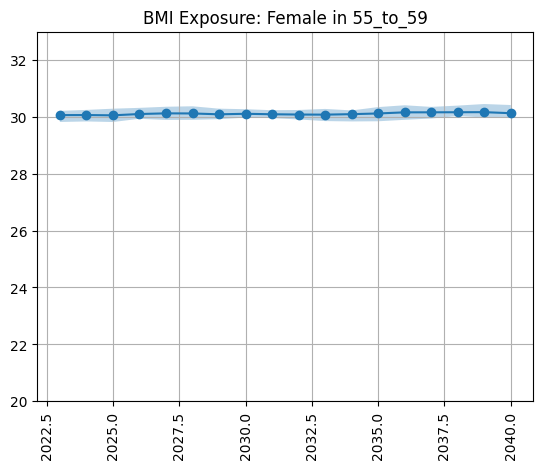

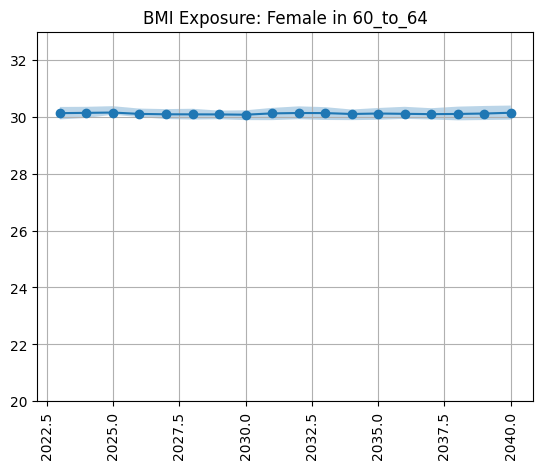

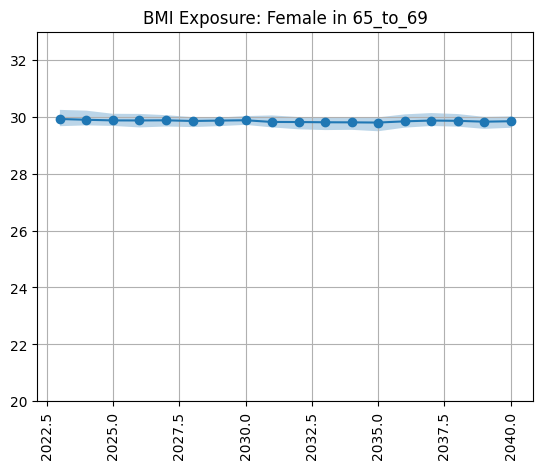

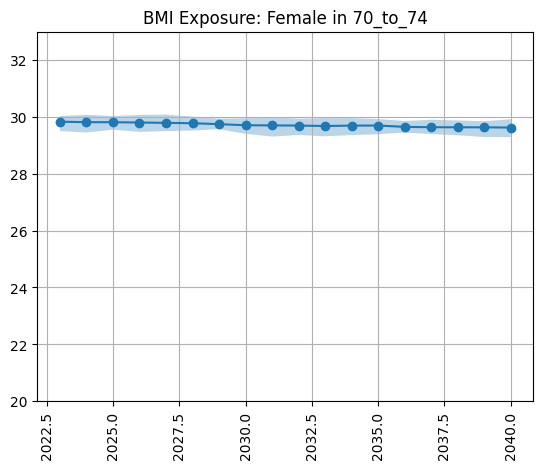

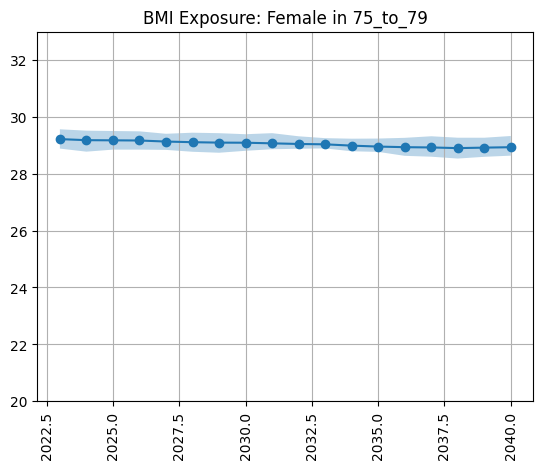

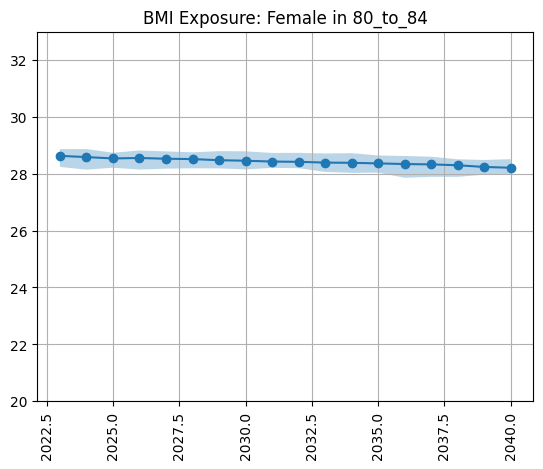

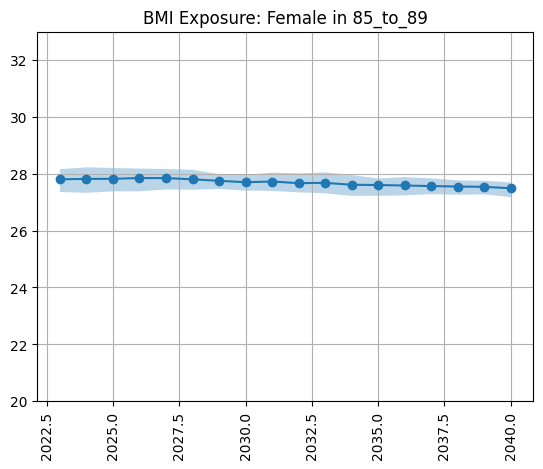

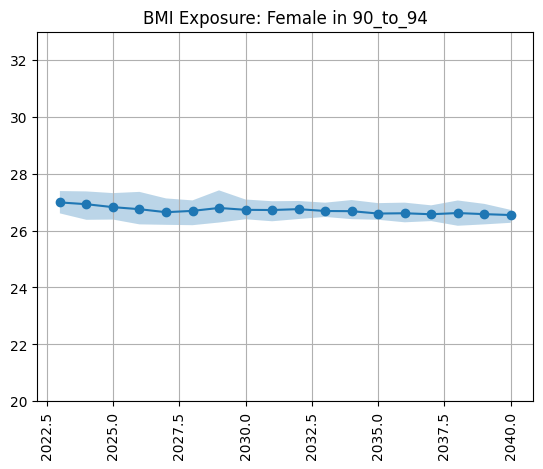

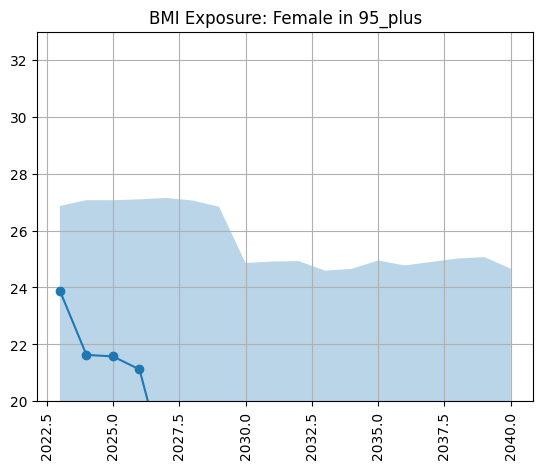

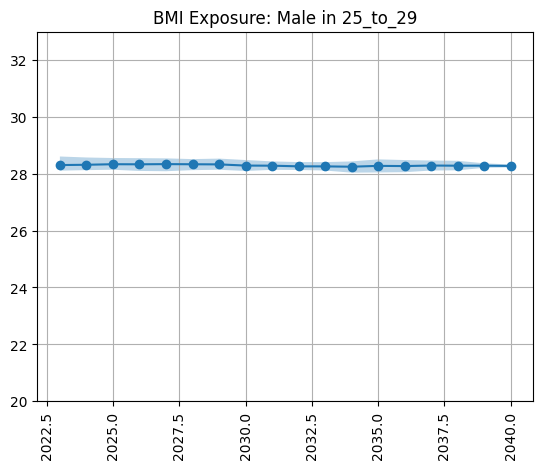

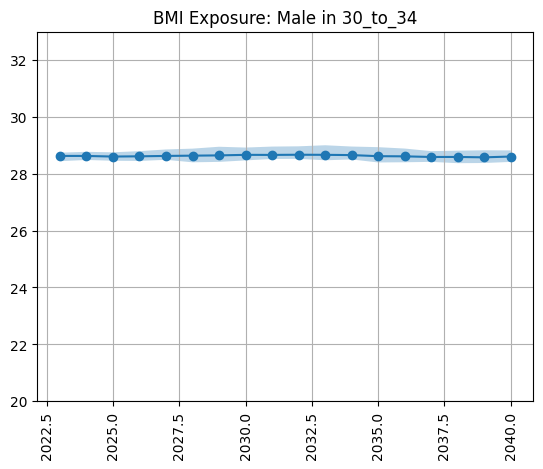

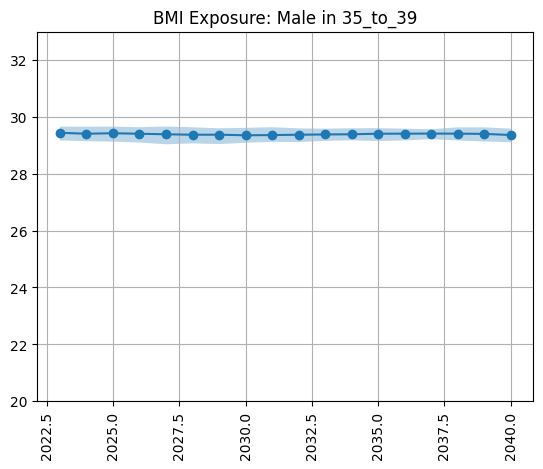

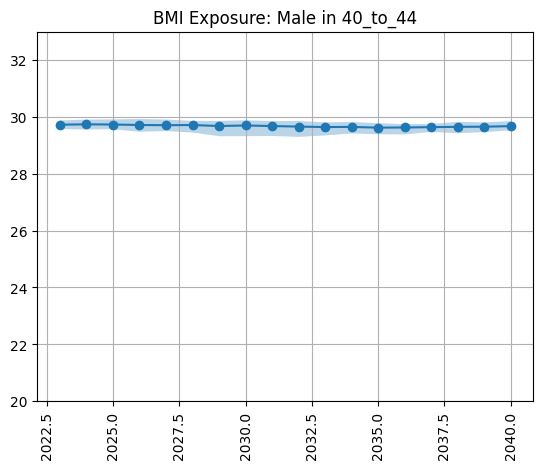

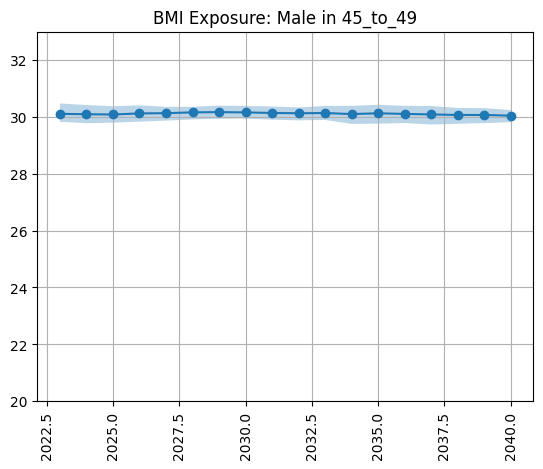

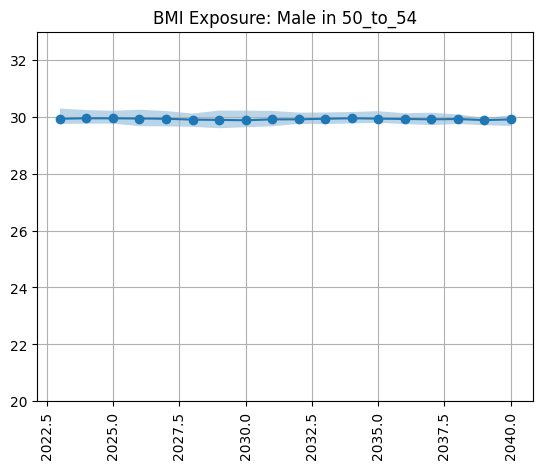

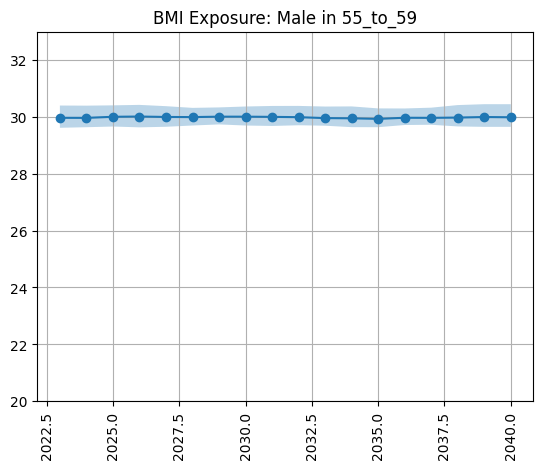

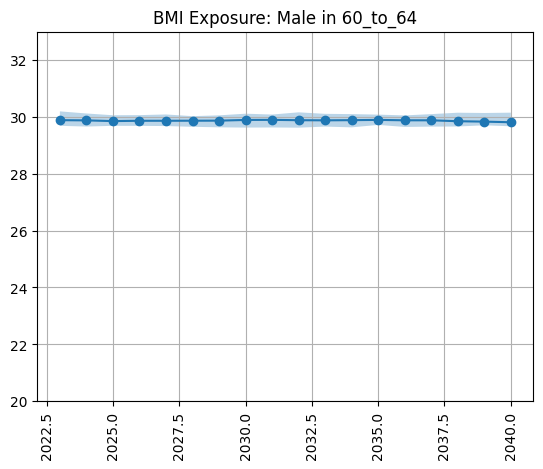

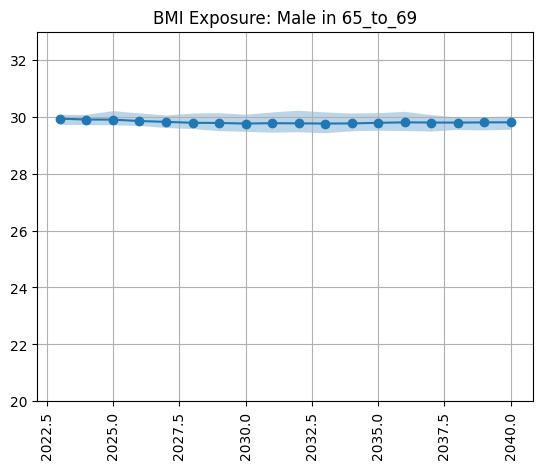

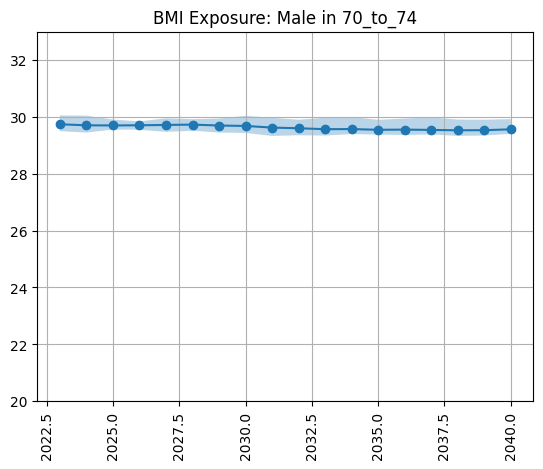

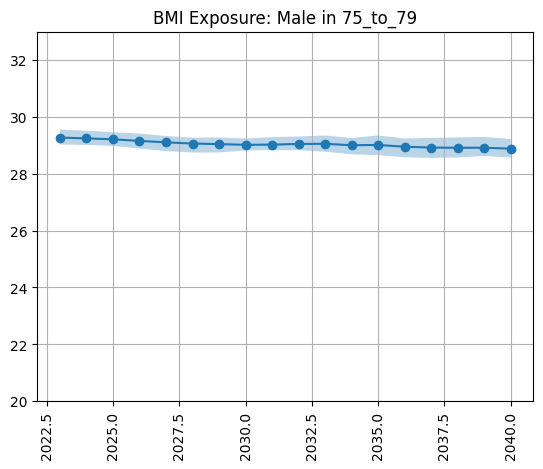

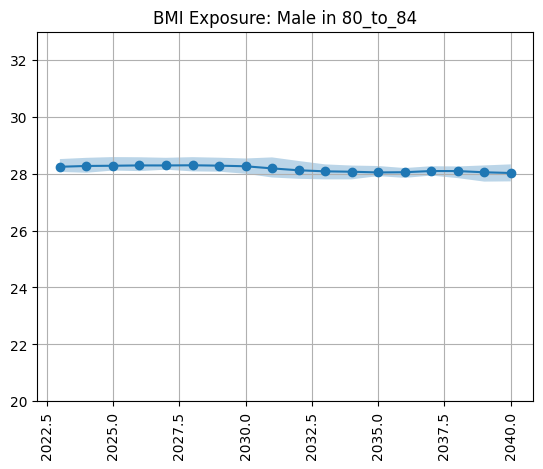

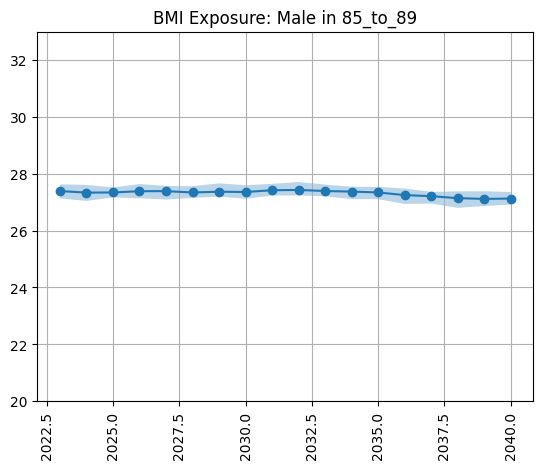

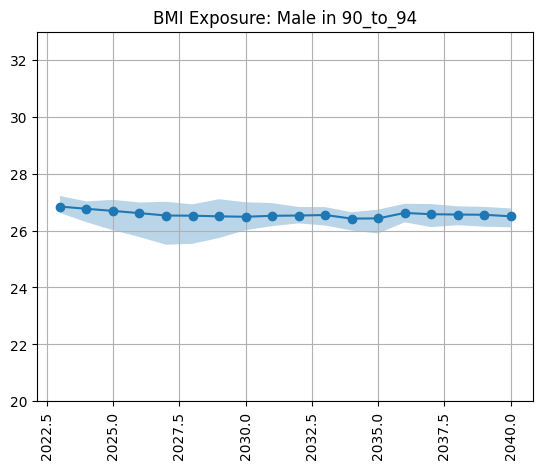

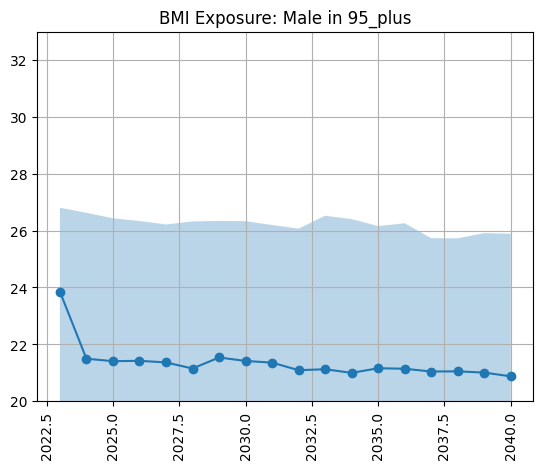

In [13]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [47]:
sbp_exp = risk_exp.loc[(risk_exp['risk']=='high_systolic_blood_pressure') & (risk_exp['scenario']=='baseline')]
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']

In [48]:
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,Female,2023,109.112073,109.317515,107.116393,111.826113
1,25_to_29,Female,2024,109.117534,109.280817,107.223640,111.824024
2,25_to_29,Female,2025,109.092997,109.312725,107.127387,111.949032
3,25_to_29,Female,2026,109.160754,109.263544,107.163194,111.836533
4,25_to_29,Female,2027,109.133698,109.365940,107.078782,111.729789


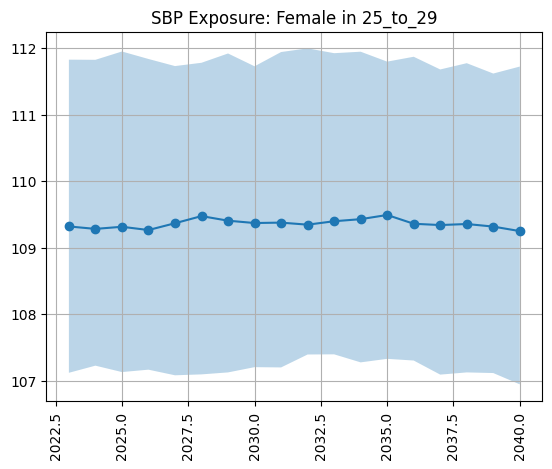

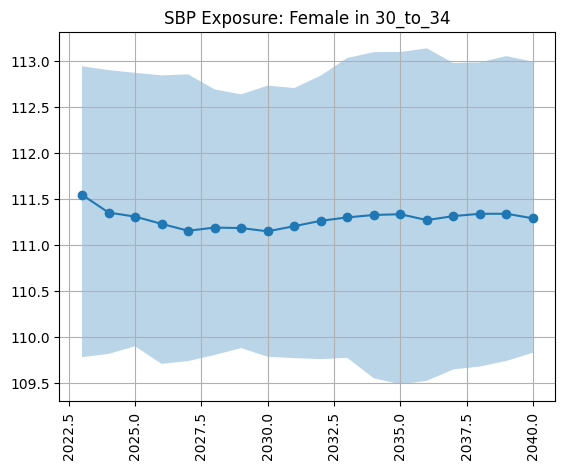

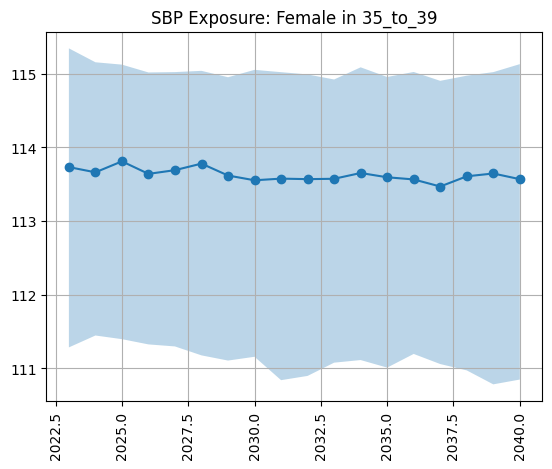

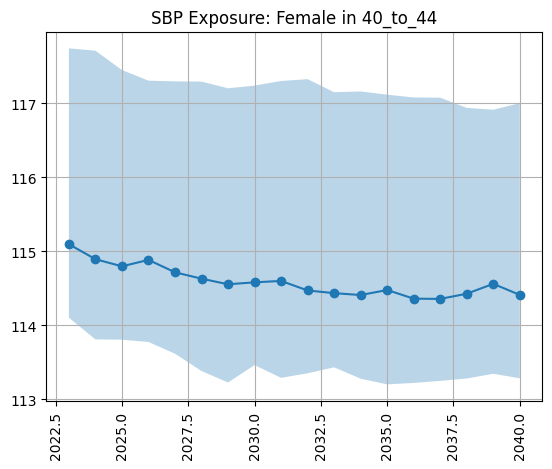

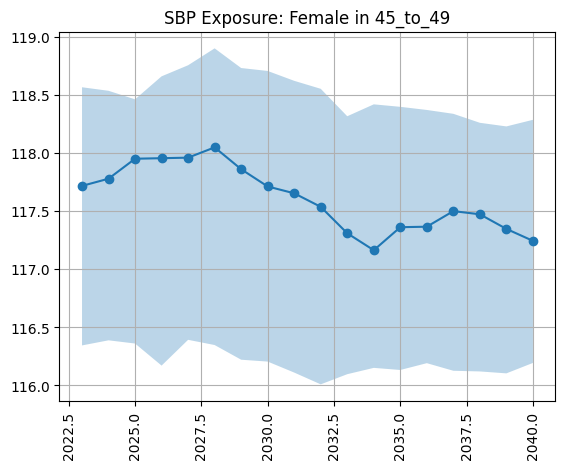

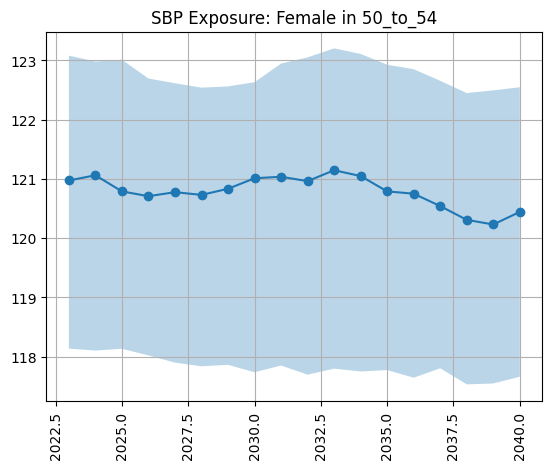

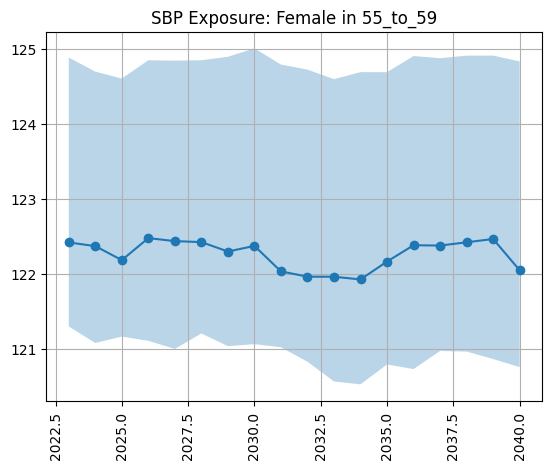

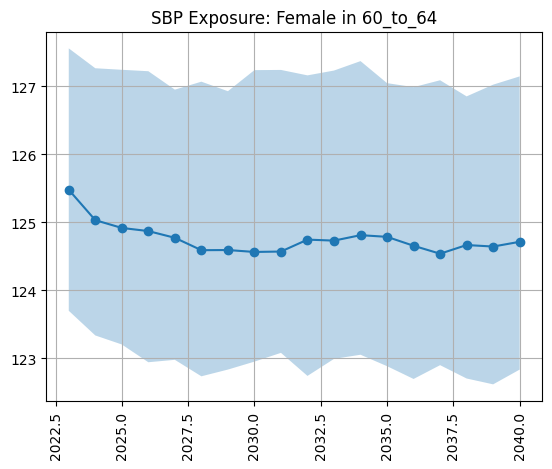

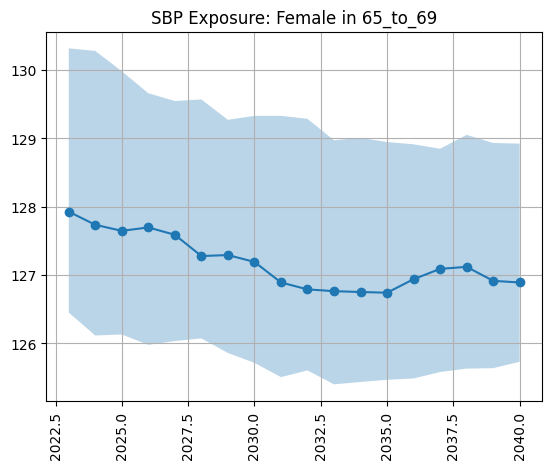

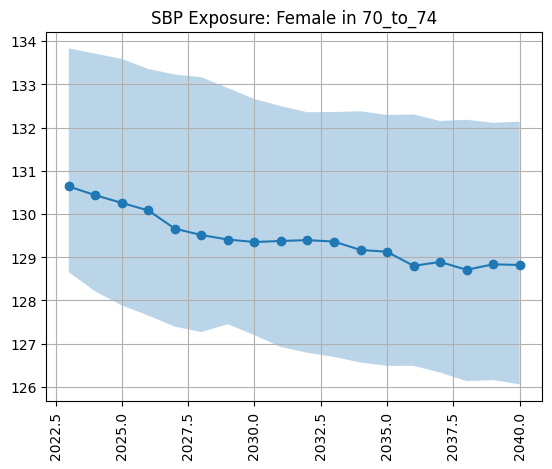

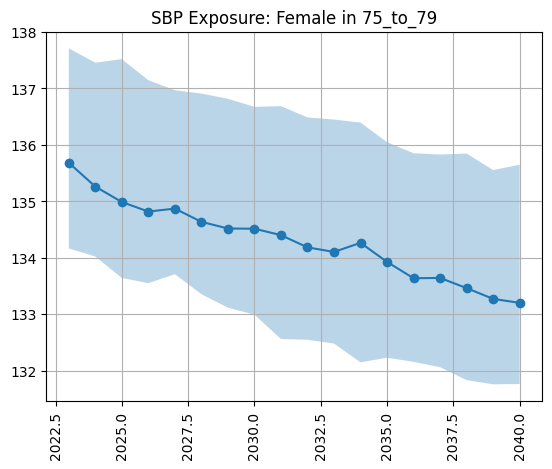

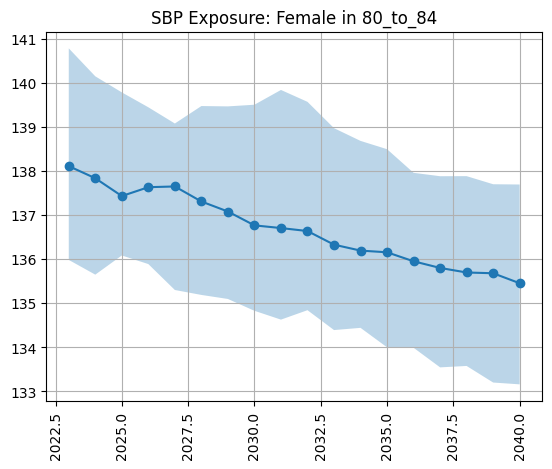

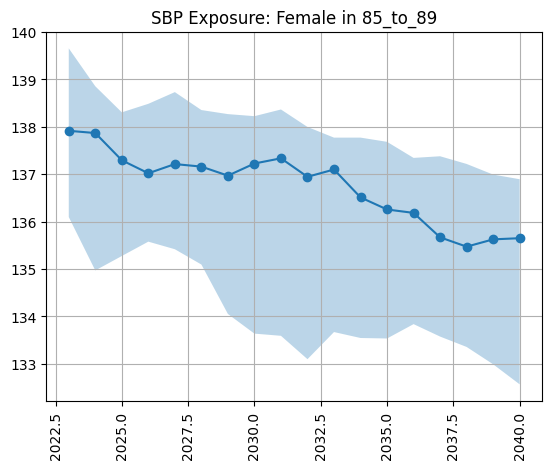

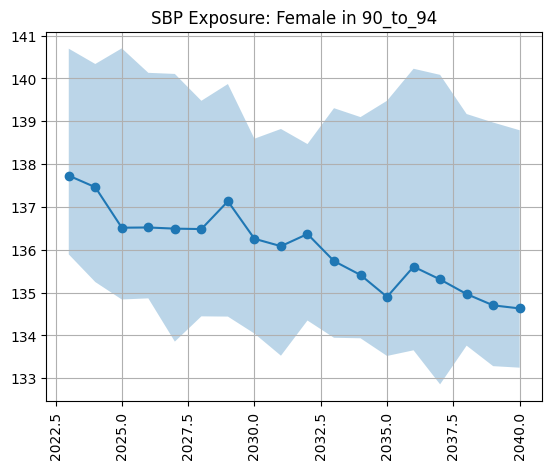

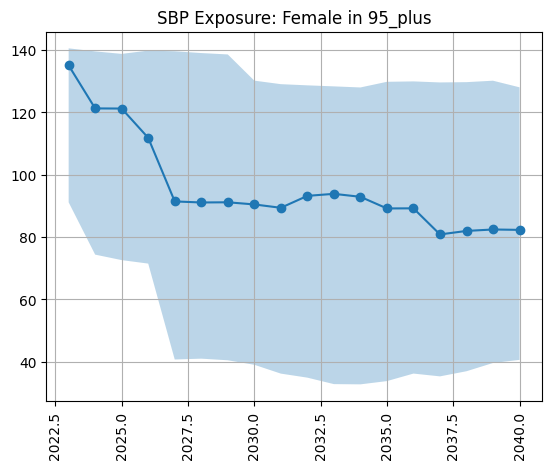

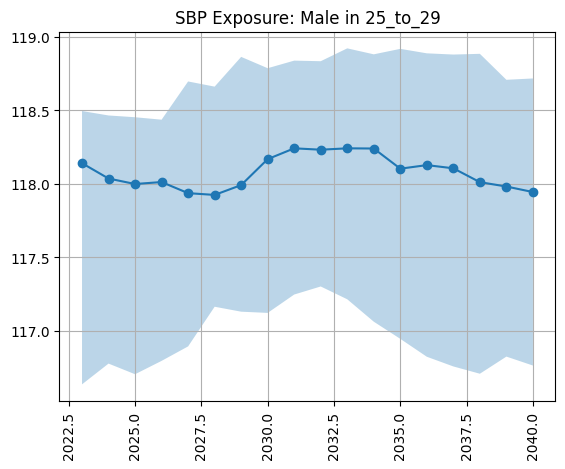

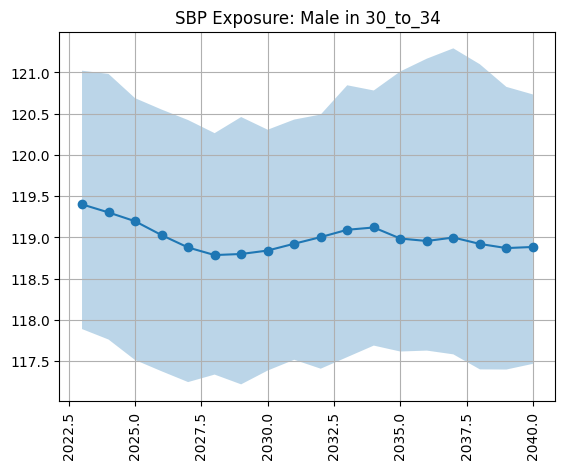

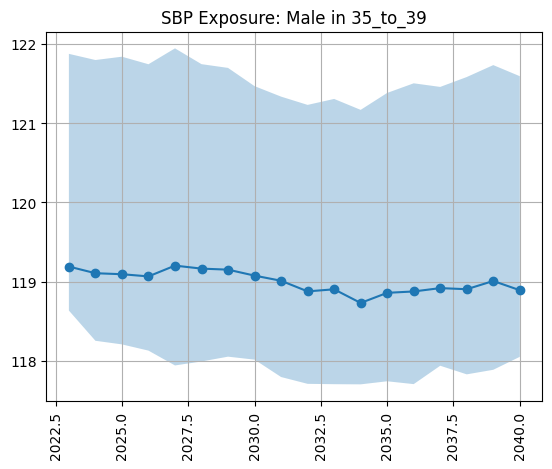

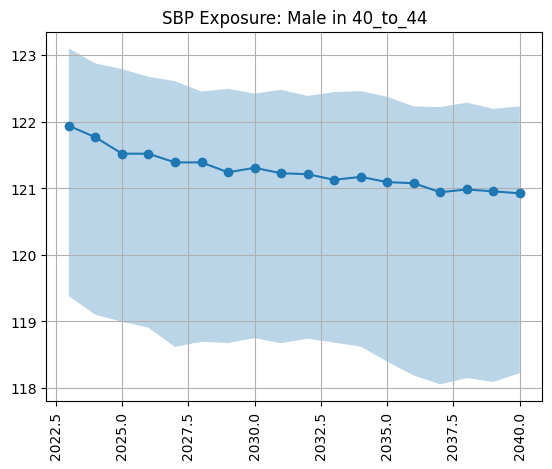

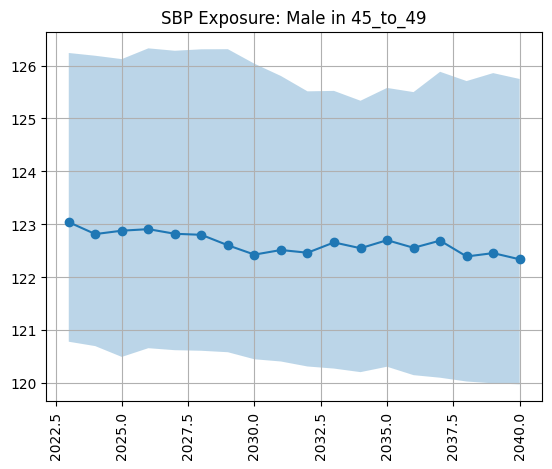

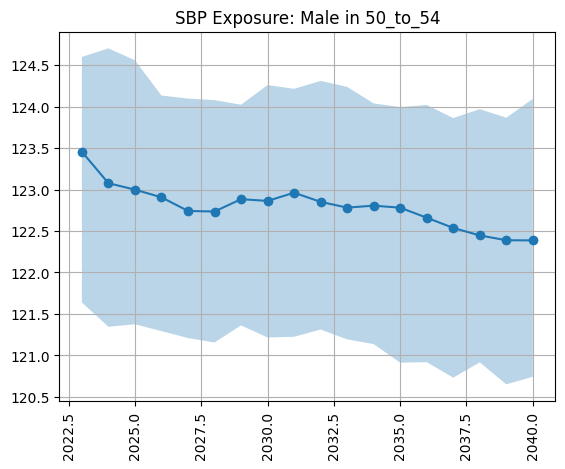

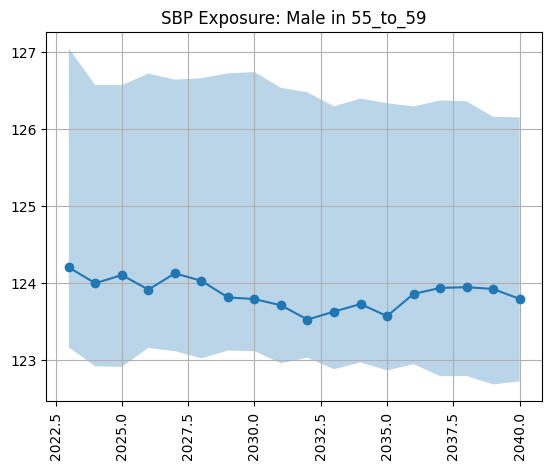

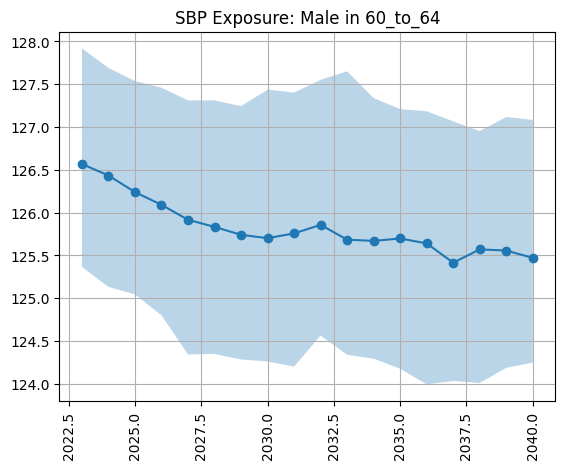

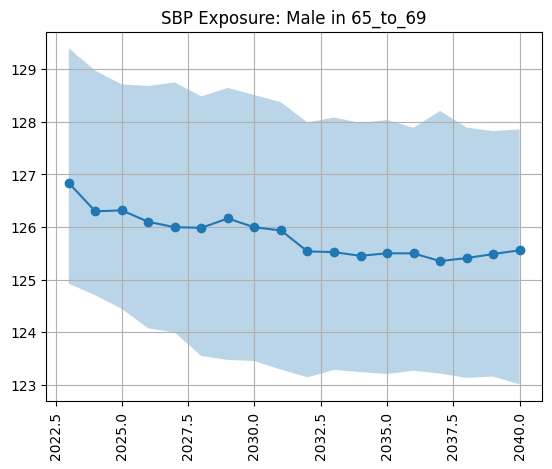

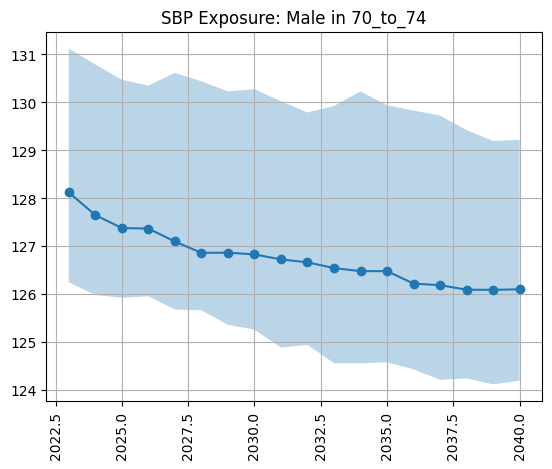

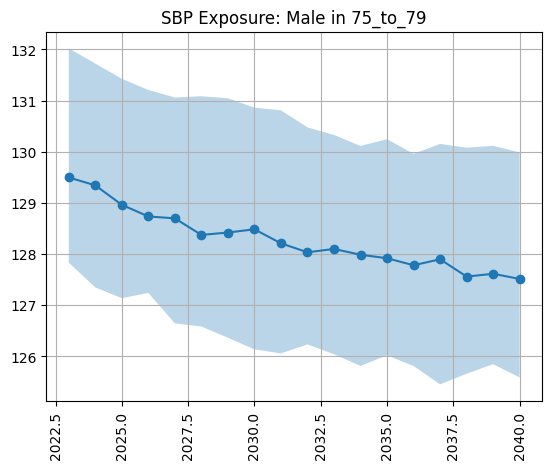

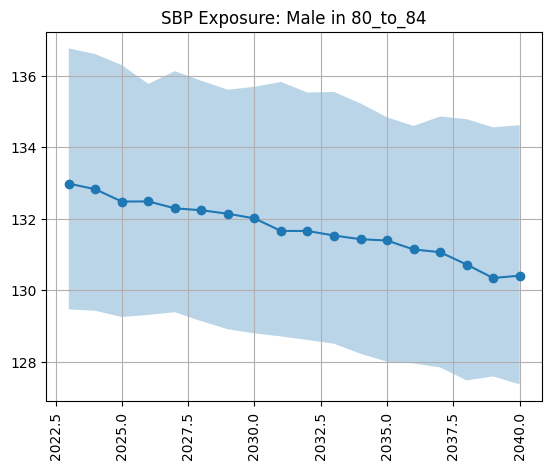

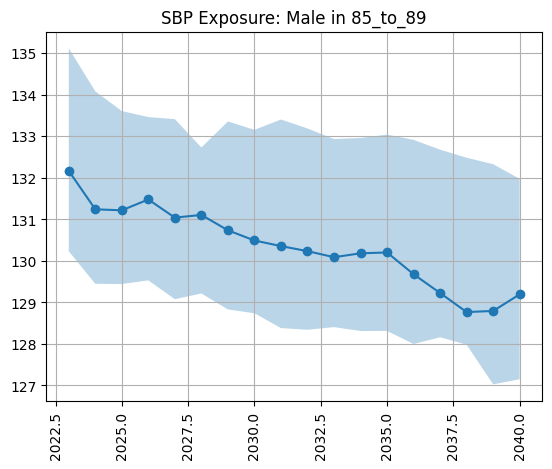

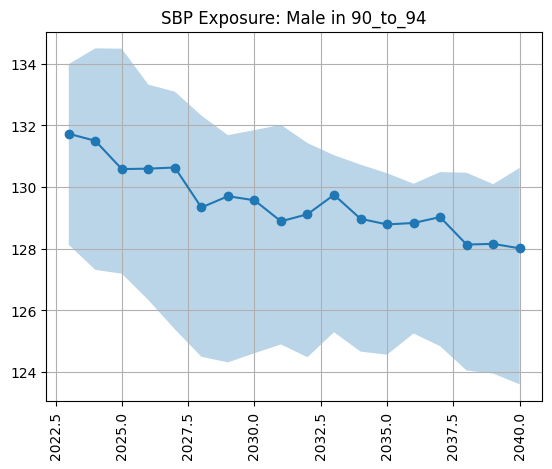

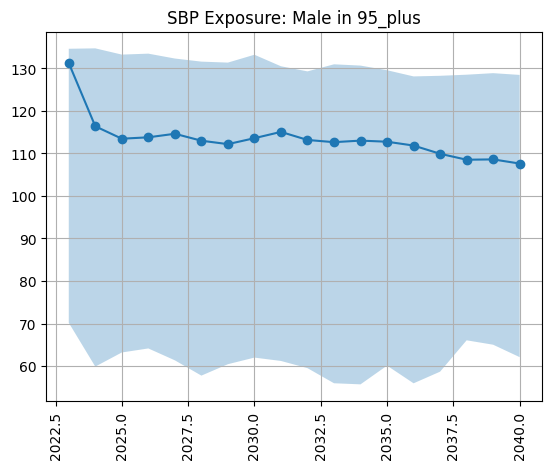

In [49]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['50%'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [54]:
ldl_exp = risk_exp.loc[(risk_exp['risk']=='high_ldl_cholesterol') & (risk_exp['scenario']=='baseline')]
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,2.648116,2.549623,2.727767
1,25_to_29,Female,2024,2.649923,2.549179,2.726757
2,25_to_29,Female,2025,2.650467,2.550519,2.718204
3,25_to_29,Female,2026,2.653745,2.555229,2.723474
4,25_to_29,Female,2027,2.656474,2.557548,2.725717


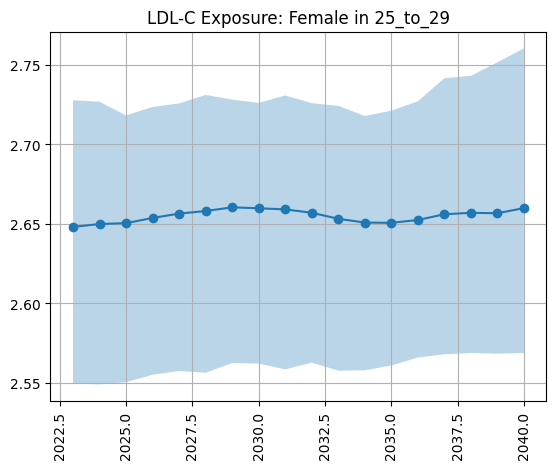

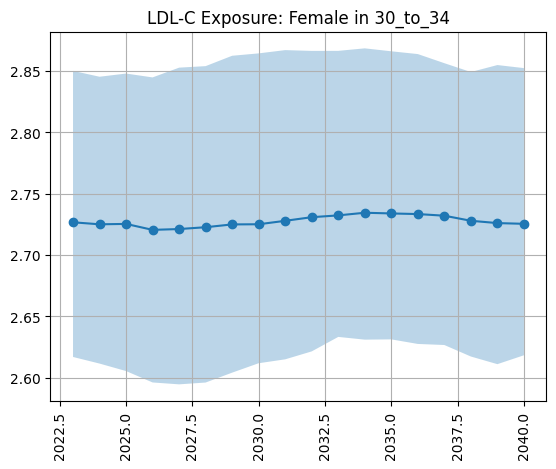

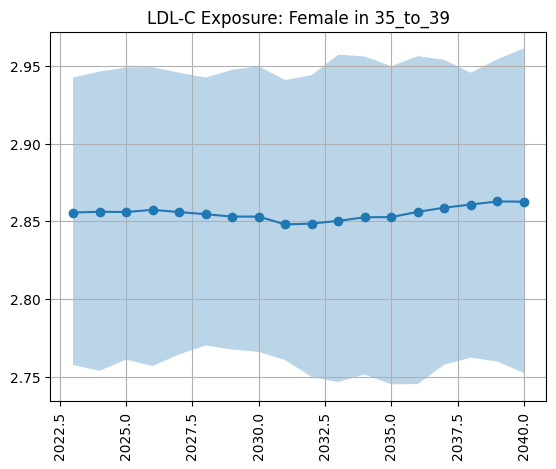

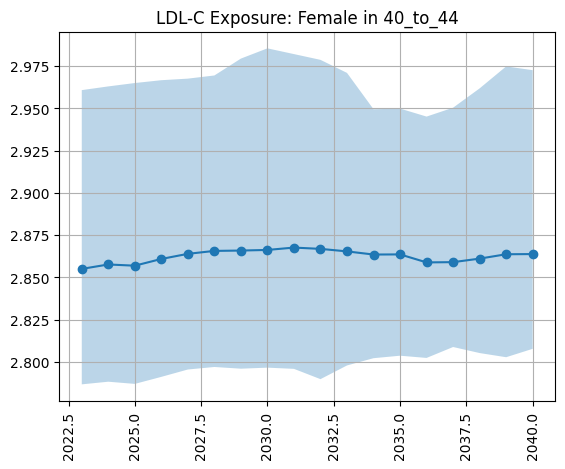

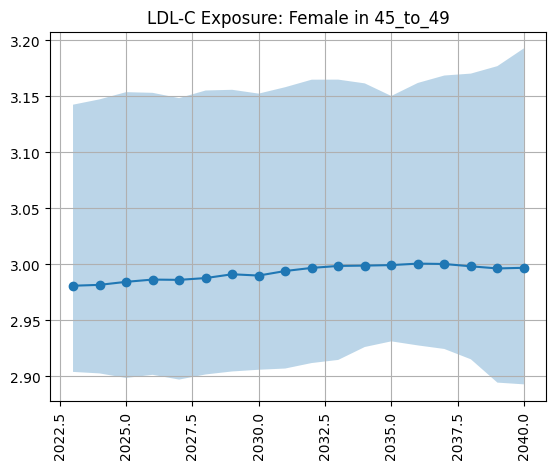

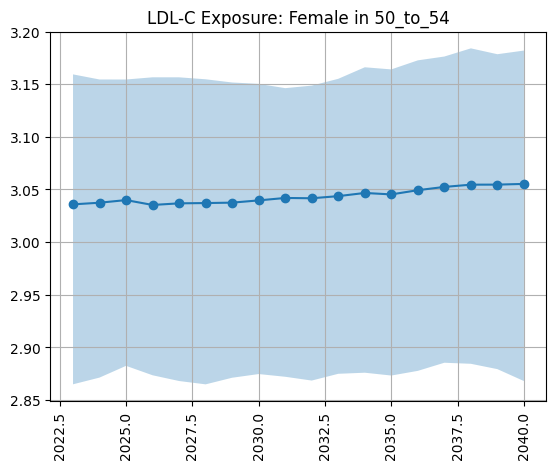

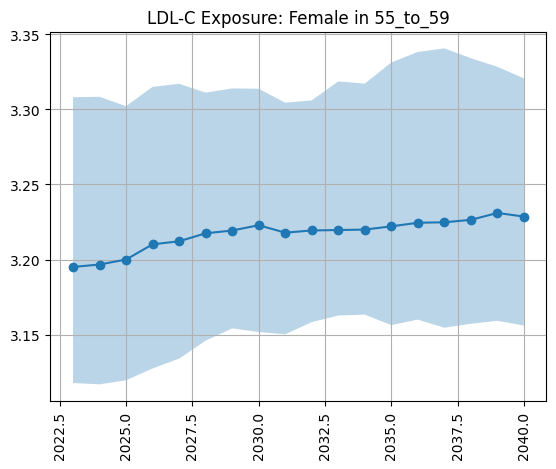

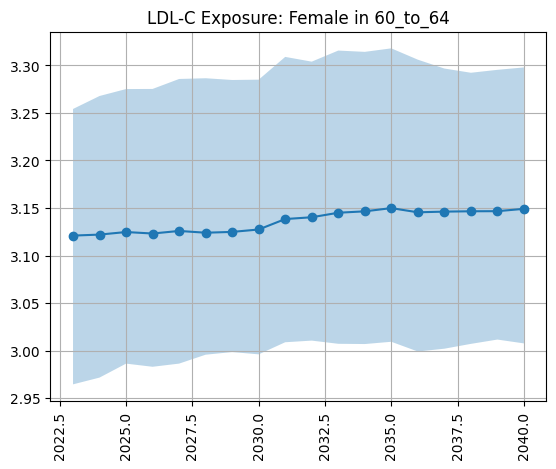

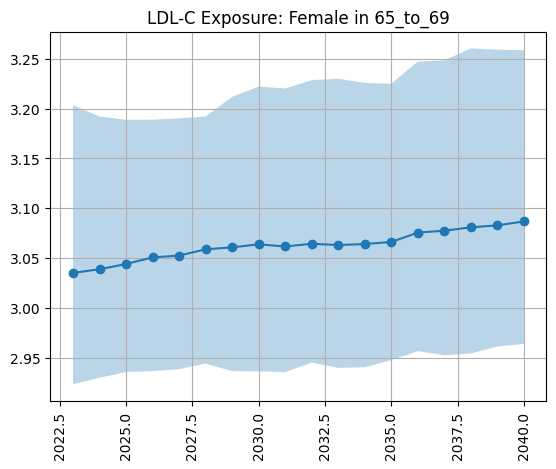

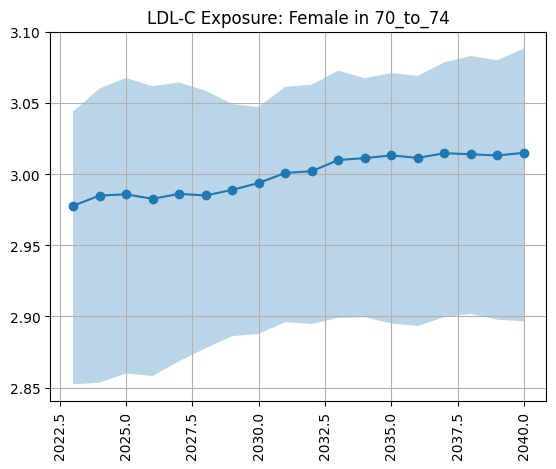

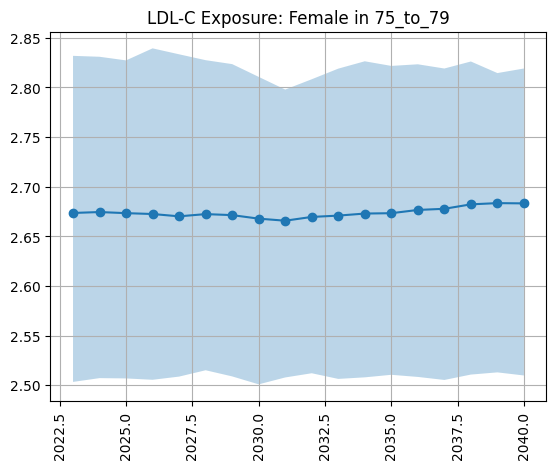

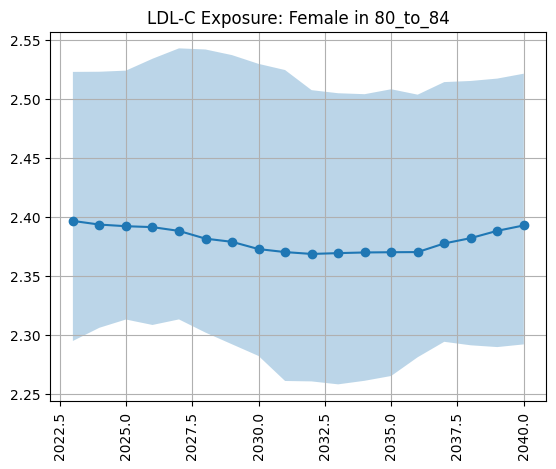

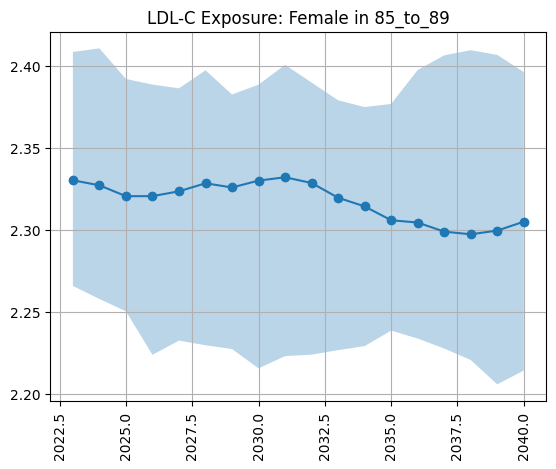

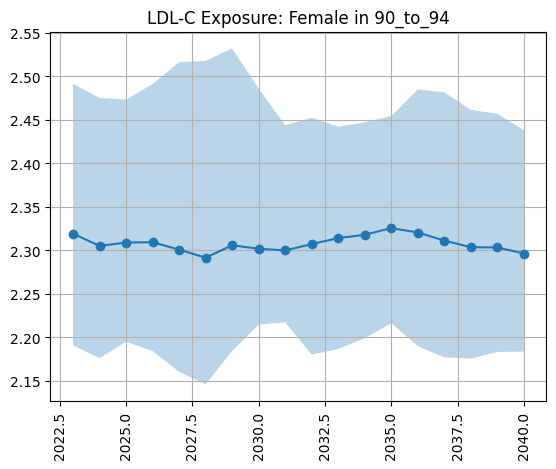

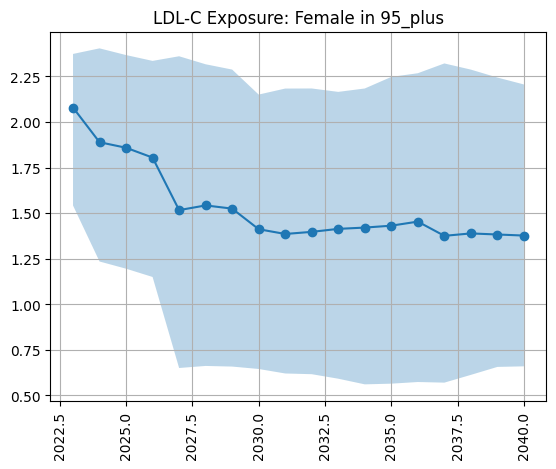

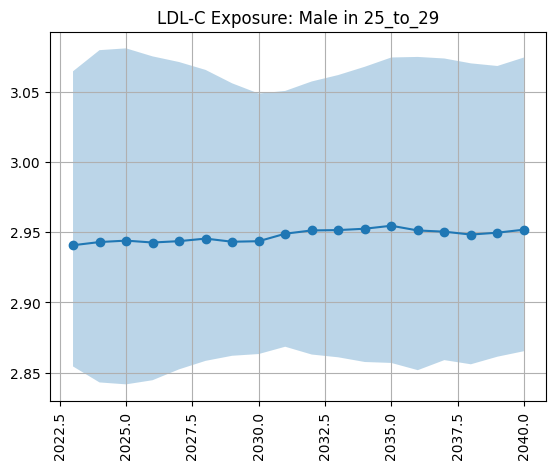

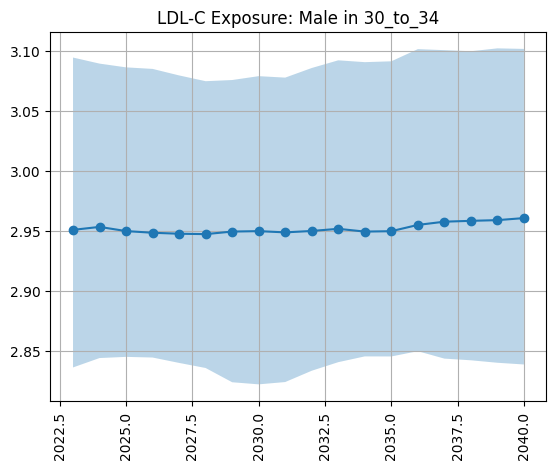

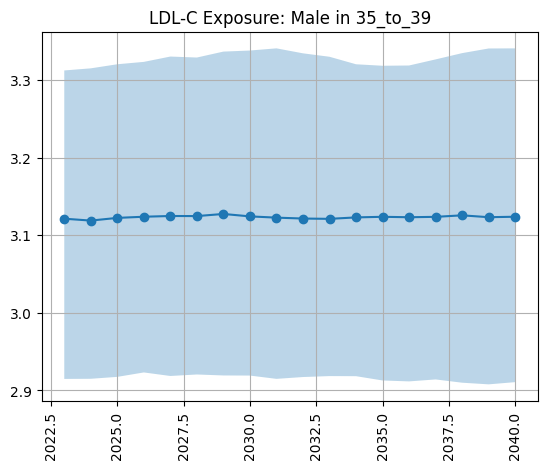

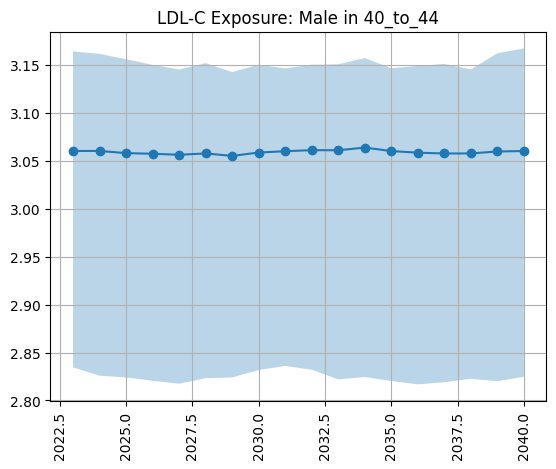

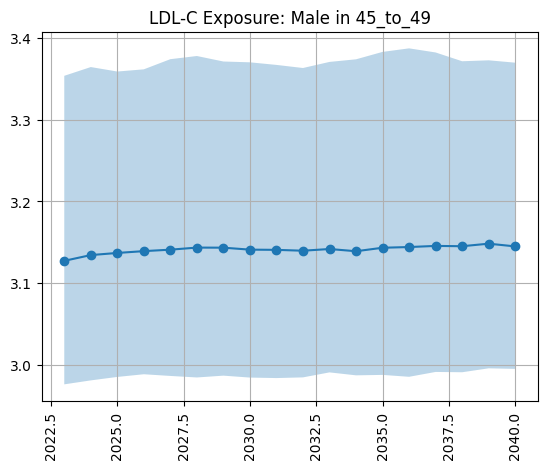

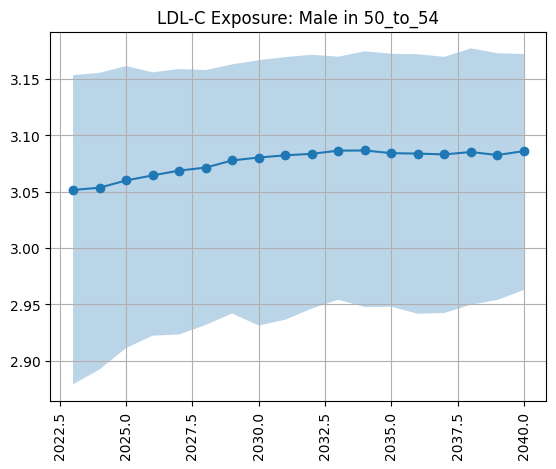

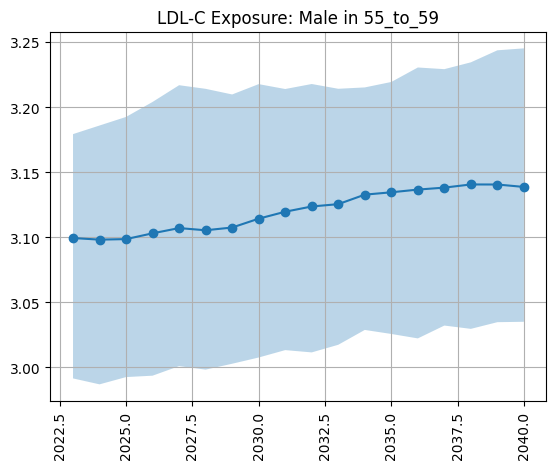

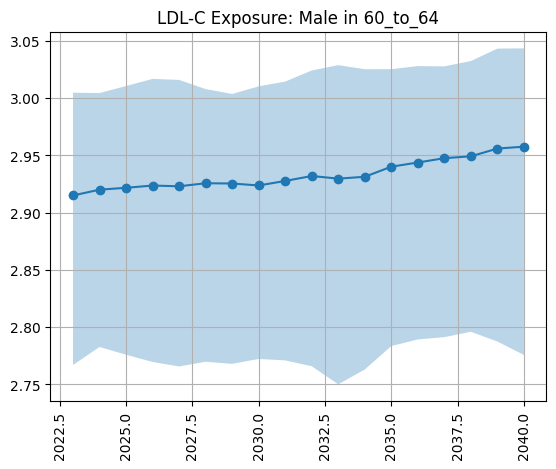

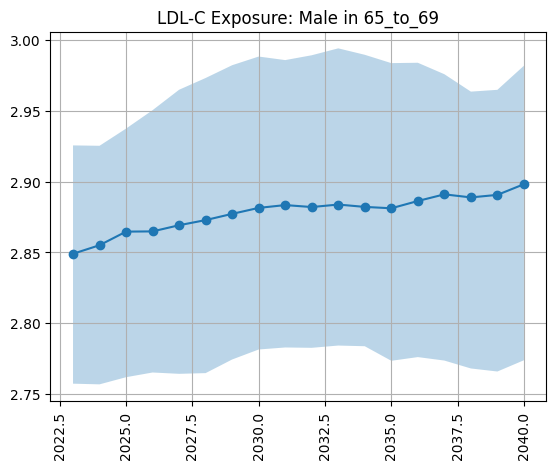

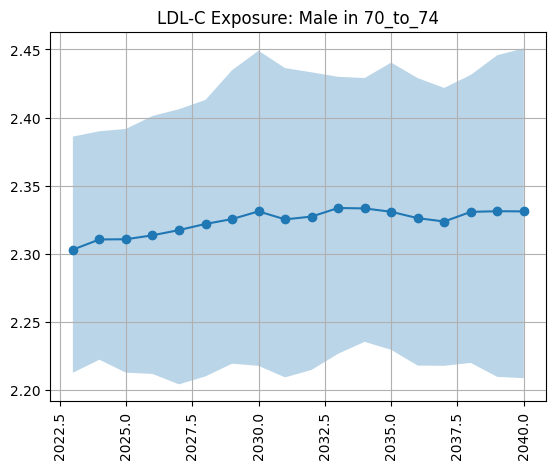

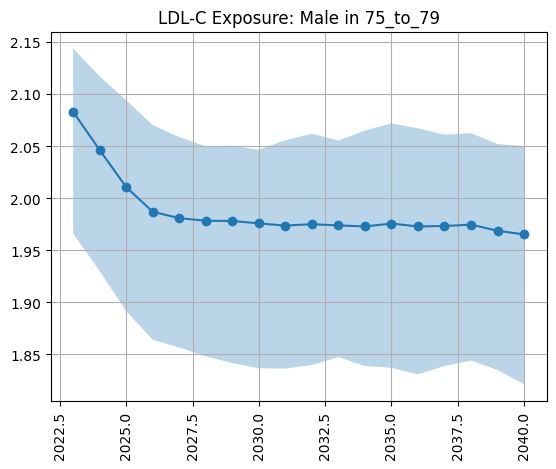

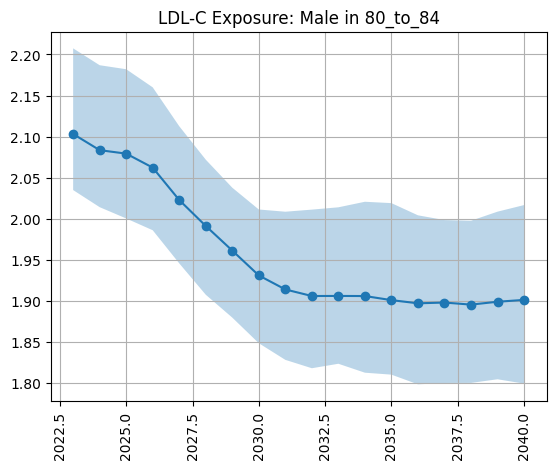

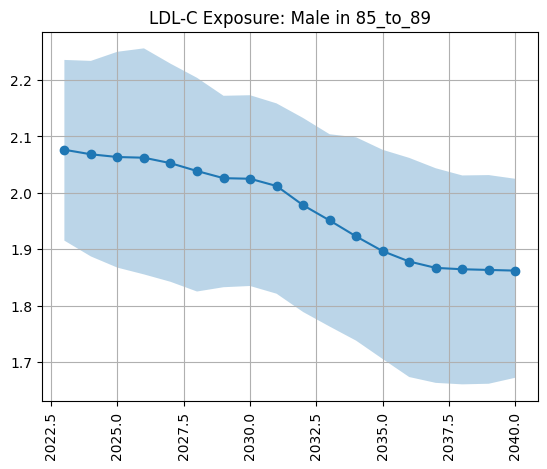

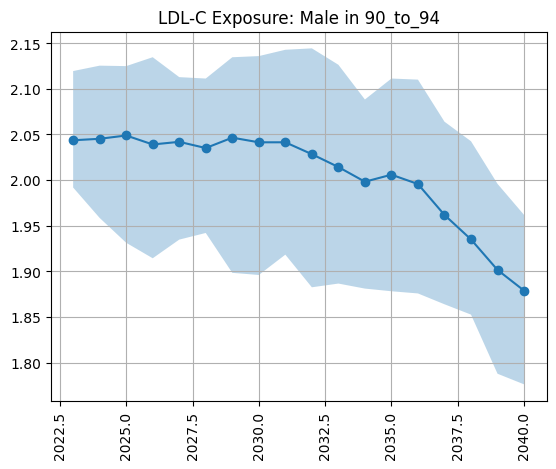

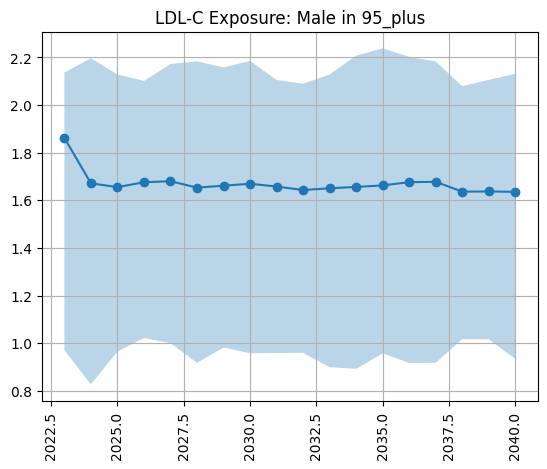

In [55]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [56]:
fpg_exp = risk_exp.loc[(risk_exp['risk']=='high_fasting_plasma_glucose')  & (risk_exp['scenario']=='baseline')]
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,5.319470,4.822715,5.736735
1,25_to_29,Female,2024,5.318831,4.822224,5.747615
2,25_to_29,Female,2025,5.320716,4.828258,5.750481
3,25_to_29,Female,2026,5.323328,4.812404,5.758066
4,25_to_29,Female,2027,5.322078,4.814192,5.756035


In [57]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [25]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [27]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/washington.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [31]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['washington']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [33]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
#bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
#bmi_art['sex'] = np.where(bmi_art['sex'] == 'Female', 'female', 'male')
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,29.033412,29.033224,28.757366,29.300440,Washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,29.632278,29.631791,29.332102,29.905088,Washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,29.949943,29.951277,29.684073,30.227876,Washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,30.112389,30.112918,29.850097,30.399662,Washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,30.238533,30.235057,29.936267,30.522230,Washington,exposure,45_to_49


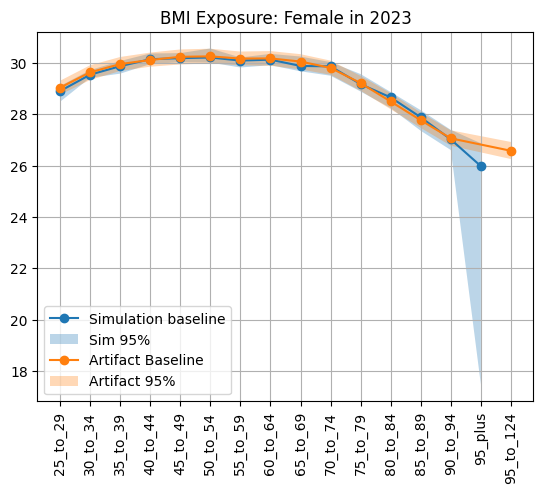

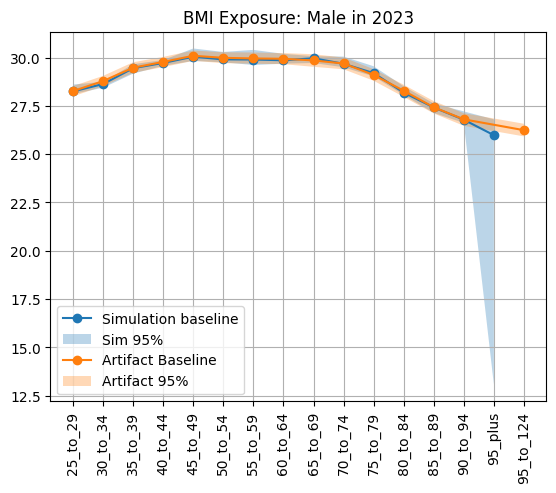

In [63]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

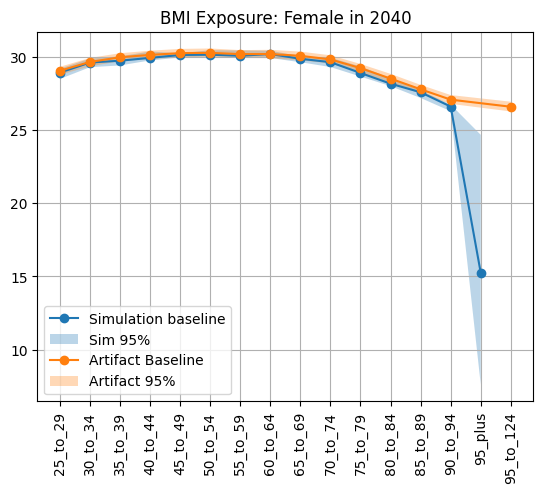

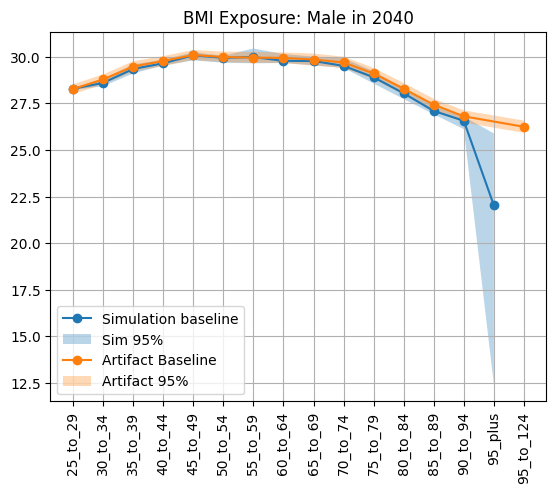

In [41]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [42]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,109.038118,109.062796,106.405986,111.725097,Washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,111.225071,111.256994,108.811490,113.590849,Washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,113.783436,113.782741,111.085901,116.355446,Washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,115.639212,115.571440,113.099469,118.525573,Washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,118.694697,118.645973,116.152041,121.444385,Washington,exposure,45_to_49


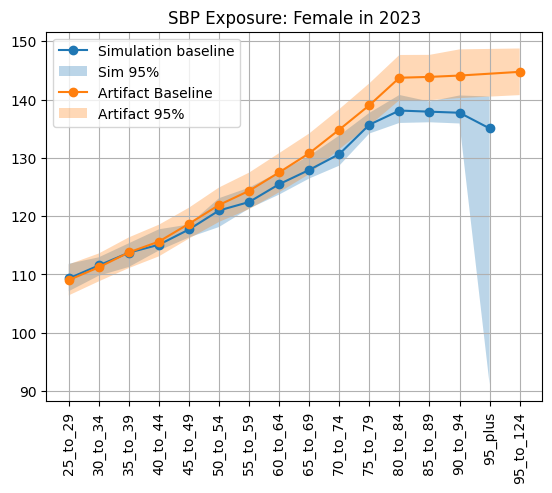

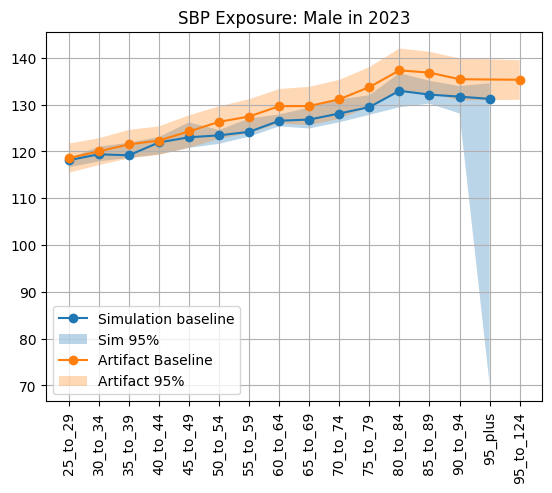

In [50]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

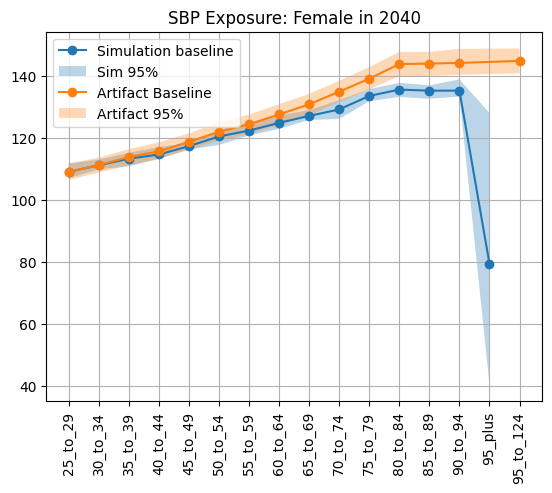

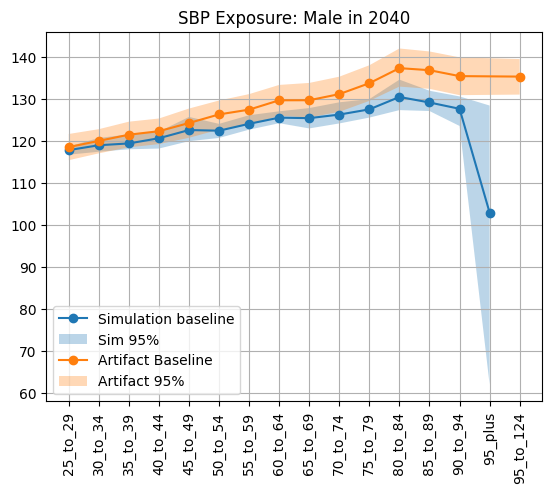

In [51]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [52]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.653726,2.652674,2.501467,2.832722,Washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.722218,2.720300,2.564508,2.893812,Washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.845212,2.846297,2.685848,3.008155,Washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.886024,2.886978,2.722389,3.045544,Washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,3.017583,3.018424,2.840927,3.188939,Washington,exposure,45_to_49


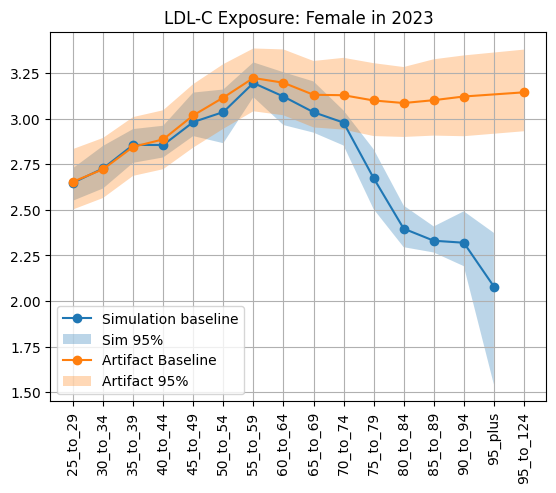

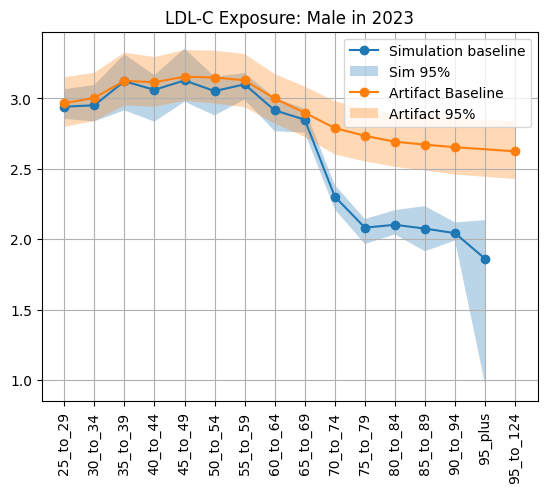

In [58]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

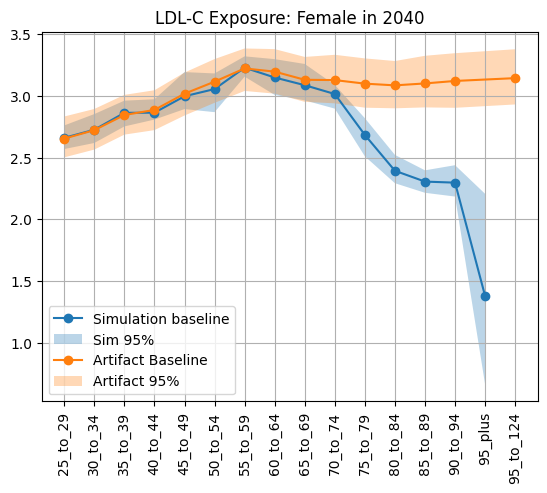

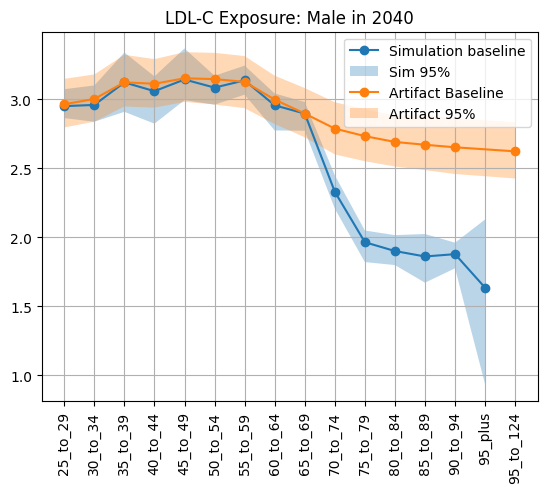

In [59]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [60]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,5.269120,5.252123,4.547909,6.017223,Washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,5.436337,5.431789,4.784969,6.196334,Washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,5.519157,5.495740,4.721254,6.442020,Washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,5.593661,5.578179,4.811193,6.427358,Washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,5.732924,5.725901,4.948982,6.575077,Washington,exposure,45_to_49


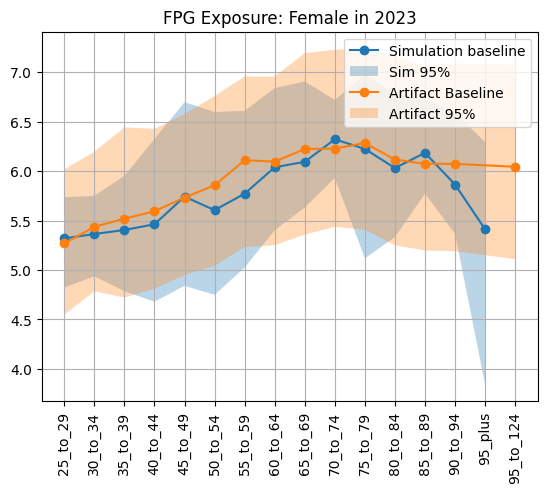

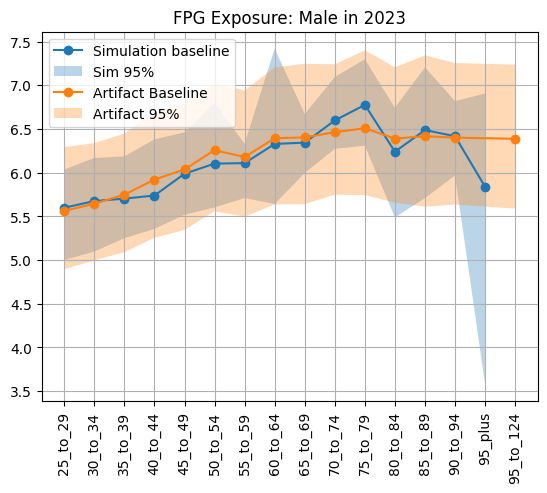

In [61]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

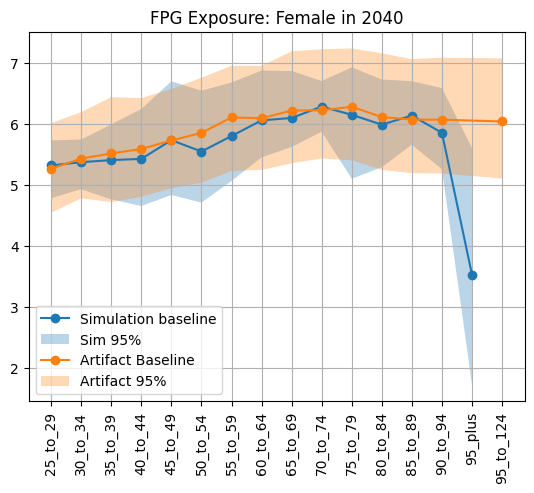

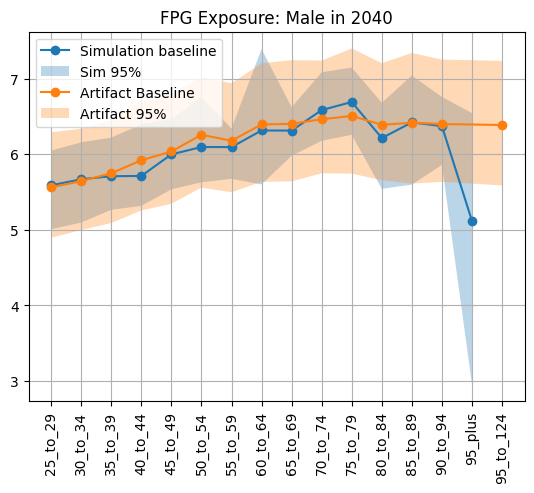

In [62]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad